In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn
import scipy 
from scipy.stats import nbinom
import seaborn as sns
from statsmodels.iolib.summary2 import summary_col

import warnings
warnings.filterwarnings("ignore")

# __observamos la naturaleza de los datos__

In [51]:
#leemos el archivo
df=pd.read_csv("machine_failure_data.csv")
df.describe(include="all")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Date              142193 non-null  object 
 1   Location          142193 non-null  int64  
 2   Min_Temp          141556 non-null  float64
 3   Max_Temp          141871 non-null  float64
 4   Leakage           140787 non-null  float64
 5   Evaporation       81350 non-null   float64
 6   Electricity       74377 non-null   float64
 7   Parameter1_Dir    132863 non-null  object 
 8   Parameter1_Speed  132923 non-null  float64
 9   Parameter2_9am    132180 non-null  object 
 10  Parameter2_3pm    138415 non-null  object 
 11  Parameter3_9am    140845 non-null  float64
 12  Parameter3_3pm    139563 non-null  float64
 13  Parameter4_9am    140419 non-null  float64
 14  Parameter4_3pm    138583 non-null  float64
 15  Parameter5_9am    128179 non-null  float64
 16  Parameter5_3pm    12

In [52]:
df.dtypes


Date                 object
Location              int64
Min_Temp            float64
Max_Temp            float64
Leakage             float64
Evaporation         float64
Electricity         float64
Parameter1_Dir       object
Parameter1_Speed    float64
Parameter2_9am       object
Parameter2_3pm       object
Parameter3_9am      float64
Parameter3_3pm      float64
Parameter4_9am      float64
Parameter4_3pm      float64
Parameter5_9am      float64
Parameter5_3pm      float64
Parameter6_9am      float64
Parameter6_3pm      float64
Parameter7_9am      float64
Parameter7_3pm      float64
Failure_today        object
dtype: object

Limpiamos los datos de nan y rellenamos con la media, y usamos las variables numericas para visulizar una matriz de correlacion para empezar a identificar variables utiles para nuestros modelos

In [53]:


def matriz_correlacion_limpia(df, umbral_nan=0.1):
    df_numerico = df.select_dtypes(include='number').copy()

    # Eliminamos columnas con más del umbral permitido de nan
    columnas_validas = df_numerico.columns[df_numerico.isnull().mean() <= umbral_nan]
    df_filtrado = df_numerico[columnas_validas]

    #rellenamos nan con la media
    df_filtrado = df_filtrado.fillna(df_filtrado.mean())

    #calculamos la matriz de correlacion
    corr = df_filtrado.corr()

    #grafico
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title("Matriz de Correlación (con limpieza de NaN)")
    plt.show()

    return df_filtrado 


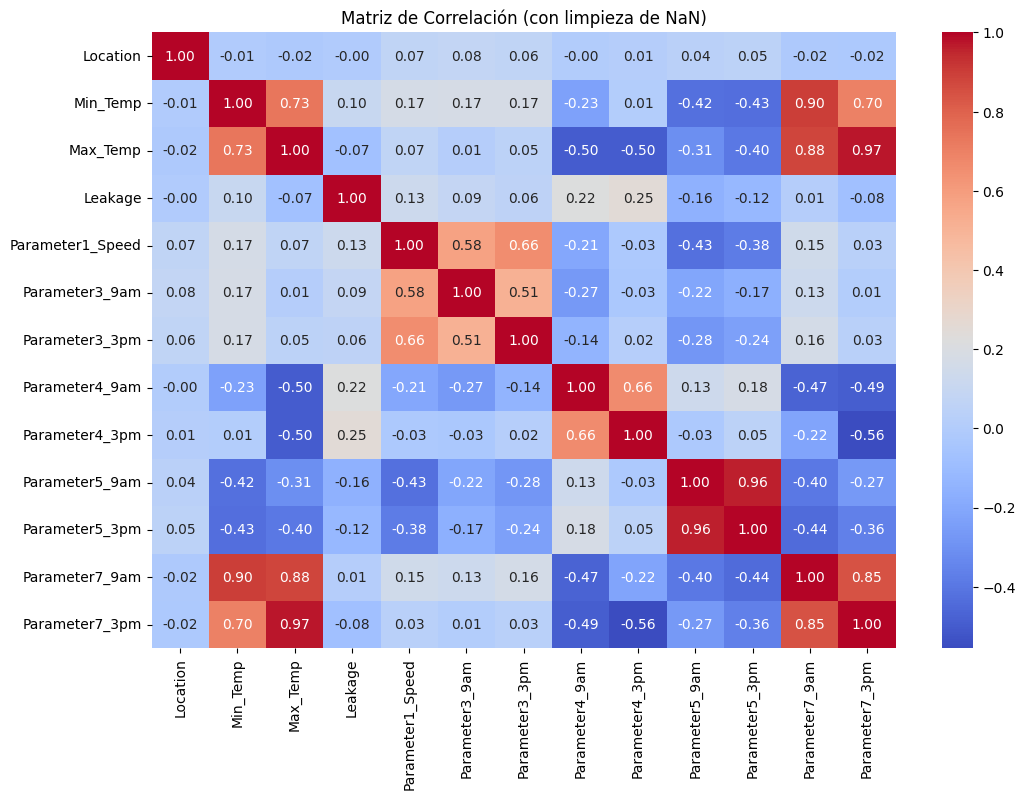

In [54]:

df_filtrado=matriz_correlacion_limpia(df)

In [55]:

df_filtrado=pd.concat([df_filtrado, df["Failure_today"]])

In [56]:
print(df.shape, "                ", df_filtrado.shape)

(142193, 22)                  (284386, 14)


In [57]:
df_filtrado["Failure_today"]=df_filtrado["Failure_today"]
df_filtrado.info()
print("           ")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 284386 entries, 0 to 142192
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Location          142193 non-null  float64
 1   Min_Temp          142193 non-null  float64
 2   Max_Temp          142193 non-null  float64
 3   Leakage           142193 non-null  float64
 4   Parameter1_Speed  142193 non-null  float64
 5   Parameter3_9am    142193 non-null  float64
 6   Parameter3_3pm    142193 non-null  float64
 7   Parameter4_9am    142193 non-null  float64
 8   Parameter4_3pm    142193 non-null  float64
 9   Parameter5_9am    142193 non-null  float64
 10  Parameter5_3pm    142193 non-null  float64
 11  Parameter7_9am    142193 non-null  float64
 12  Parameter7_3pm    142193 non-null  float64
 13  Failure_today     140787 non-null  object 
dtypes: float64(13), object(1)
memory usage: 32.5+ MB
           
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 ent

# __checkpoint limpiamos datos para el modelo (Pregunta1)__

Librerias

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn
import scipy 
from scipy.stats import nbinom
import seaborn as sns
from statsmodels.iolib.summary2 import summary_col

import warnings
warnings.filterwarnings("ignore")

In [59]:


#leemos el archivo
df=pd.read_csv("machine_failure_data.csv")
df.describe(include="all")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Date              142193 non-null  object 
 1   Location          142193 non-null  int64  
 2   Min_Temp          141556 non-null  float64
 3   Max_Temp          141871 non-null  float64
 4   Leakage           140787 non-null  float64
 5   Evaporation       81350 non-null   float64
 6   Electricity       74377 non-null   float64
 7   Parameter1_Dir    132863 non-null  object 
 8   Parameter1_Speed  132923 non-null  float64
 9   Parameter2_9am    132180 non-null  object 
 10  Parameter2_3pm    138415 non-null  object 
 11  Parameter3_9am    140845 non-null  float64
 12  Parameter3_3pm    139563 non-null  float64
 13  Parameter4_9am    140419 non-null  float64
 14  Parameter4_3pm    138583 non-null  float64
 15  Parameter5_9am    128179 non-null  float64
 16  Parameter5_3pm    12

In [60]:
nan_por_columna = df.isna().sum()
nan_por_columna

# el parametro 6 9am posee
proporcion=53657/df.shape[0]
print("proporcion de nan del parametro 6 9am: ",proporcion*100,"%")
proporcion= nan_por_columna[-4]/df.shape[0]
print("proporcion de nan del parametro 6 3pm: ",proporcion*100,"%")



proporcion de nan del parametro 6 9am:  37.73533155640573 %
proporcion de nan del parametro 6 3pm:  40.15246882757942 %


In [61]:
#se eliminan por un numero demasiado alto de nan

df = df.drop(columns=["Parameter6_3pm"])
df= df.drop(columns=["Parameter6_9am"])

# vemos el df
df

#esto ahora no tiene el parametro 6

,Date,Location,Min_Temp,Max_Temp,Leakage,Evaporation,Electricity,Parameter1_Dir,Parameter1_Speed,Parameter2_9am,Parameter2_3pm,Parameter3_9am,Parameter3_3pm,Parameter4_9am,Parameter4_3pm,Parameter5_9am,Parameter5_3pm,Parameter7_9am,Parameter7_3pm,Failure_today
0,12/1/2008,3,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No
1,12/2/2008,3,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No
2,12/3/2008,3,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No
3,12/4/2008,3,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No
4,12/5/2008,3,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142188,6/20/2017,42,3.5,21.8,0.0,NaN,NaN,E,31.0,ESE,E,15.0,13.0,59.0,27.0,1024.7,1021.2,9.4,20.9,No
142189,6/21/2017,42,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,10.1,22.4,No
142190,6/22/2017,42,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,10.9,24.5,No
142191,6/23/2017,42,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,12.5,26.1,No


__CORECCION DE NAN VARIABLES 2/21__
PARAMETRO 6 AM Y PM

In [62]:

def resumen_nan(df):
    total = df.shape[0]
    resumen = pd.DataFrame({
        "NaN_count": df.isna().sum(),
        "Total": total,
        "NaN_percent": df.isna().sum() / total
    })
    return resumen.sort_values("NaN_percent", ascending=False)


resumen_nan(df)




,NaN_count,Total,NaN_percent
Electricity,67816,142193,0.476929
Evaporation,60843,142193,0.427890
Parameter5_9am,14014,142193,0.098556
Parameter5_3pm,13981,142193,0.098324
Parameter2_9am,10013,142193,0.070418
Parameter1_Dir,9330,142193,0.065615
Parameter1_Speed,9270,142193,0.065193
Parameter2_3pm,3778,142193,0.026570
Parameter4_3pm,3610,142193,0.025388
Parameter7_3pm,2726,142193,0.019171


In [63]:
#sacamos electricity y evaporation

df= df.drop(columns=["Electricity"])
df= df.drop(columns=["Evaporation"])

#df con un total de 3 columnas menos



In [64]:
resumen_nan(df)

#ahora tenemos muchos menos datos porque eran nan generados por los datos ya sacados(columnas anteriores)

,NaN_count,Total,NaN_percent
Parameter5_9am,14014,142193,0.098556
Parameter5_3pm,13981,142193,0.098324
Parameter2_9am,10013,142193,0.070418
Parameter1_Dir,9330,142193,0.065615
Parameter1_Speed,9270,142193,0.065193
Parameter2_3pm,3778,142193,0.026570
Parameter4_3pm,3610,142193,0.025388
Parameter7_3pm,2726,142193,0.019171
Parameter3_3pm,2630,142193,0.018496
Parameter4_9am,1774,142193,0.012476


In [65]:
df.dtypes

Date                 object
Location              int64
Min_Temp            float64
Max_Temp            float64
Leakage             float64
Parameter1_Dir       object
Parameter1_Speed    float64
Parameter2_9am       object
Parameter2_3pm       object
Parameter3_9am      float64
Parameter3_3pm      float64
Parameter4_9am      float64
Parameter4_3pm      float64
Parameter5_9am      float64
Parameter5_3pm      float64
Parameter7_9am      float64
Parameter7_3pm      float64
Failure_today        object
dtype: object

In [66]:
#generamos una copia 
df_copia=df.copy()

#realizaremos el experimento de borrar las filas donde haya almenos un nan, y ver si se reducen en menos de un 10% los datos es aceptable
df_copia = df_copia.dropna()

In [67]:
resumen_nan(df_copia)

,NaN_count,Total,NaN_percent
Date,0,112925,0.0
Location,0,112925,0.0
Min_Temp,0,112925,0.0
Max_Temp,0,112925,0.0
Leakage,0,112925,0.0
Parameter1_Dir,0,112925,0.0
Parameter1_Speed,0,112925,0.0
Parameter2_9am,0,112925,0.0
Parameter2_3pm,0,112925,0.0
Parameter3_9am,0,112925,0.0


## __fin limpieza de nan__

__TRABAJAMOS CON DF_COPIA1__

In [68]:
#ya que no tenemos nan, procedemos a cambiar el formato de las variables object
df_nan=df_copia.copy()

df_nan.info()

#corregimos los indicces
df_nan = df_nan.reset_index(drop=True)
df_nan

<class 'pandas.core.frame.DataFrame'>
Index: 112925 entries, 0 to 142192
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Date              112925 non-null  object 
 1   Location          112925 non-null  int64  
 2   Min_Temp          112925 non-null  float64
 3   Max_Temp          112925 non-null  float64
 4   Leakage           112925 non-null  float64
 5   Parameter1_Dir    112925 non-null  object 
 6   Parameter1_Speed  112925 non-null  float64
 7   Parameter2_9am    112925 non-null  object 
 8   Parameter2_3pm    112925 non-null  object 
 9   Parameter3_9am    112925 non-null  float64
 10  Parameter3_3pm    112925 non-null  float64
 11  Parameter4_9am    112925 non-null  float64
 12  Parameter4_3pm    112925 non-null  float64
 13  Parameter5_9am    112925 non-null  float64
 14  Parameter5_3pm    112925 non-null  float64
 15  Parameter7_9am    112925 non-null  float64
 16  Parameter7_3pm    112925 

,Date,Location,Min_Temp,Max_Temp,Leakage,Parameter1_Dir,Parameter1_Speed,Parameter2_9am,Parameter2_3pm,Parameter3_9am,Parameter3_3pm,Parameter4_9am,Parameter4_3pm,Parameter5_9am,Parameter5_3pm,Parameter7_9am,Parameter7_3pm,Failure_today
0,12/1/2008,3,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No
1,12/2/2008,3,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No
2,12/3/2008,3,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No
3,12/4/2008,3,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No
4,12/5/2008,3,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112920,6/20/2017,42,3.5,21.8,0.0,E,31.0,ESE,E,15.0,13.0,59.0,27.0,1024.7,1021.2,9.4,20.9,No
112921,6/21/2017,42,2.8,23.4,0.0,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,10.1,22.4,No
112922,6/22/2017,42,3.6,25.3,0.0,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,10.9,24.5,No
112923,6/23/2017,42,5.4,26.9,0.0,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,12.5,26.1,No


## __TRANSFORMACION DE DATOS__

__funcion para ajustar los parametros que son object__

In [69]:
def reemplazar_por_primera_letra(df, nombre_columna):
    df[nombre_columna] = df[nombre_columna].astype(str).str.upper().str[0]
    return df

In [70]:
#ajustamos parametro1_Dir parametro 2() am y pm), puesto que la diferencia es poca y es probable que hayan diferencias mas notorias en este formato



df_nan=reemplazar_por_primera_letra(df_nan, "Parameter1_Dir")  

df_nan=reemplazar_por_primera_letra(df_nan, "Parameter2_9am")

df_nan=reemplazar_por_primera_letra(df_nan, "Parameter2_3pm")


#vemos el df_nan con los parametros ajustados
print(df_nan["Parameter1_Dir"].unique(),
df_nan["Parameter2_9am"].unique(),
df_nan["Parameter2_3pm"].unique())


['W' 'N' 'S' 'E'] ['W' 'N' 'S' 'E'] ['W' 'E' 'N' 'S']


In [71]:
df_nan["Failure_today"].value_counts()

Failure_today
No     87556
Yes    25369
Name: count, dtype: int64

Nos queda por ajustar failure today a binario, y aplicar el modelo ols, recordar que leakage tiene correlacion con la varaible dependiente, parametro 7
en am y pm tiene mucha correlacion con la temperatura min y max segun la matriz, por lo que las abstendremos del modelo(a usar juntas)

In [72]:
#pasamos a binario el failure today
def convertir_binario(df, columna):
    df[columna] = df[columna].astype(str).str.upper().map({'YES': 1, 'NO': 0})
    return df
df_nan=convertir_binario(df_nan, "Failure_today")


In [73]:
df_nan["Failure_today"].value_counts()


Failure_today
0    87556
1    25369
Name: count, dtype: int64

In [74]:
df_nan.dtypes

Date                 object
Location              int64
Min_Temp            float64
Max_Temp            float64
Leakage             float64
Parameter1_Dir       object
Parameter1_Speed    float64
Parameter2_9am       object
Parameter2_3pm       object
Parameter3_9am      float64
Parameter3_3pm      float64
Parameter4_9am      float64
Parameter4_3pm      float64
Parameter5_9am      float64
Parameter5_3pm      float64
Parameter7_9am      float64
Parameter7_3pm      float64
Failure_today         int64
dtype: object

__HACEMOS LA MATRIZ DE CORRELACION NUEVAMENTE__

In [75]:

#FUNCION DE HACER LA MATRIZ
def matriz_correlacion(df, tamaño=(12, 8), cmap='coolwarm', annot=True, fmt='.2f'):
    # Seleccionar solo columnas numéricas
    df_numerico = df.select_dtypes(include=['number'])
    
    # Calcular matriz de correlación
    correlacion = df_numerico.corr()

    # Crear el gráfico
    plt.figure(figsize=tamaño)
    sns.heatmap(correlacion, cmap=cmap, annot=annot, fmt=fmt)
    plt.title("Matriz de correlación", fontsize=16)
    plt.tight_layout()
    plt.show()


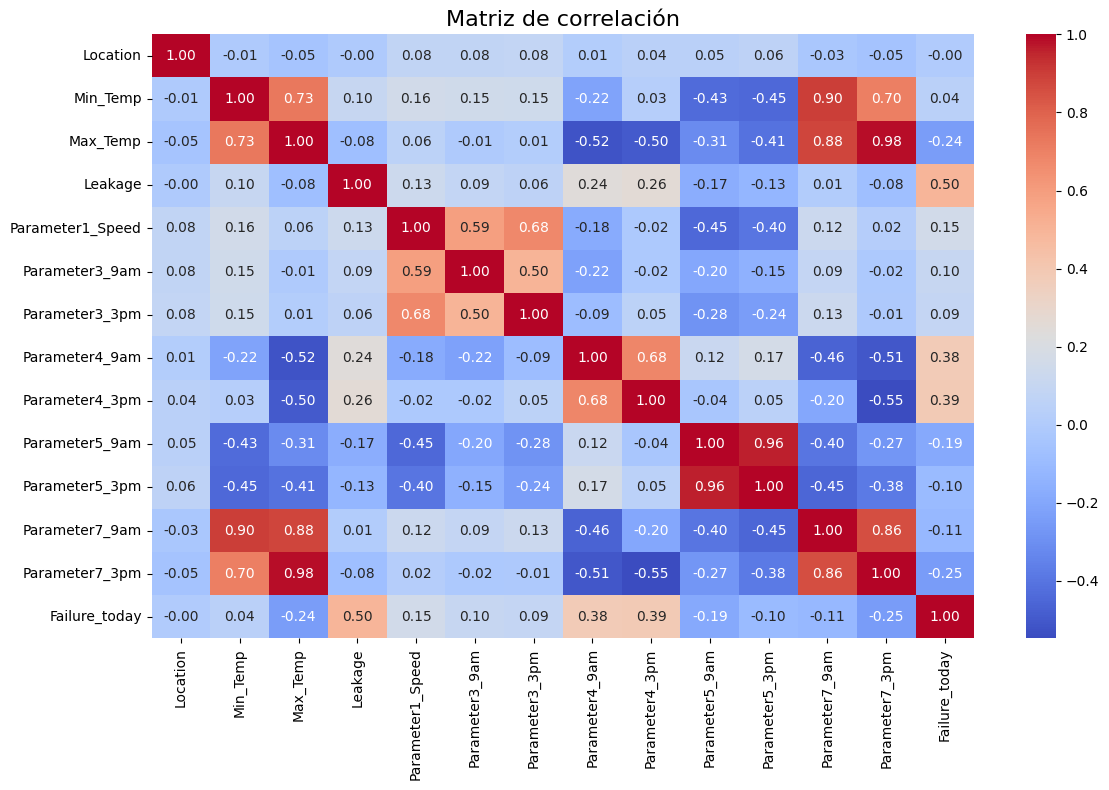

In [76]:
matriz_correlacion(df_nan, tamaño=(12,8), cmap="coolwarm", annot=True, fmt=".2f")

In [77]:
df_nan.dtypes

Date                 object
Location              int64
Min_Temp            float64
Max_Temp            float64
Leakage             float64
Parameter1_Dir       object
Parameter1_Speed    float64
Parameter2_9am       object
Parameter2_3pm       object
Parameter3_9am      float64
Parameter3_3pm      float64
Parameter4_9am      float64
Parameter4_3pm      float64
Parameter5_9am      float64
Parameter5_3pm      float64
Parameter7_9am      float64
Parameter7_3pm      float64
Failure_today         int64
dtype: object

## Fin pregunta 1

## __pregunta 2, Modelo OLS__

In [78]:
model = smf.ols("Failure_today ~ Parameter1_Speed + Parameter4_9am + Min_Temp + Parameter7_3pm ", data=df_nan).fit()
print(model.summary()) #el parametro 4 de la mañana explica mas
#df_nan.columns



                            OLS Regression Results                            
Dep. Variable:          Failure_today   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     8715.
Date:                Fri, 25 Apr 2025   Prob (F-statistic):               0.00
Time:                        00:06:05   Log-Likelihood:                -46367.
No. Observations:              112925   AIC:                         9.274e+04
Df Residuals:                  112920   BIC:                         9.279e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.3308      0.009  

__Respuesta pregunta 2:__

Se eligieron 4 variables para este modelo, dada su baja correlacion entre otras variables, y su no alta correlacion con la variable dependiente.
Luego tenemos que el aumento de una unidad de las variables: Parameter4_9am, Parameter7_3pm, Min_temp, y parameter1_speed, reflejan, respectivamente, un/a aumento(A)/Disminucion(D) de (A)0,72% ;(D) 1,8% ; (A)1,97% ; (A) 0.54% en la cifra de variable de interes: failure_today, que en este caso como es binario vendria siendo un aumento en terminos de "probabilidad", sin embargo, en realidad, por cada unidad que aumenten cada variable independiente, las cuales varian en su respectiva medida, la probabilidad de fallar cambia en aquellas unidades.





## __Pregunta 3 modelo probit__

In [79]:
probit_model = smf.probit("Failure_today ~ Parameter1_Speed + Parameter4_9am + Min_Temp + Parameter7_3pm ", data=df_nan).fit()
print(probit_model.summary())

mfx = probit_model.get_margeff()
print(mfx.summary())

Optimization terminated successfully.
         Current function value: 0.385756
         Iterations 7
                          Probit Regression Results                           
Dep. Variable:          Failure_today   No. Observations:               112925
Model:                         Probit   Df Residuals:                   112920
Method:                           MLE   Df Model:                            4
Date:                Fri, 25 Apr 2025   Pseudo R-squ.:                  0.2759
Time:                        00:06:06   Log-Likelihood:                -43562.
converged:                       True   LL-Null:                       -60159.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -3.3564      0.045    -75.269      0.000      -3.444      -3.269
Parameter1_

Respuesta pregunta 3: Los coeficientes son algo bajo(efectos marginales), donde tenemos que la velocidad y el parametro 4 afectan bastante poco la probabilidad de que falle la maquina, mas para el parametro 7 y la temperatura minima, este efecto es un poco mayor por unidad, donde es particular llama la atencion la temperatura minima, pueesto que tiene un amplio rango de valores, podria darse un efecto interesante en la probabilidad de que falle la maquina producto del aumento de la temperatura minima, donde de momento se tiene que por cada unidad que aumente la temperatura minima, la probabilidad de que falle la maquina aumenta en un 2,28%. por otro lado para el parametro 7 baja en un 2,21% la probabilidad que falle la maquina por cada unidad que aumente, la relacion contraria a la temperatura minima. 


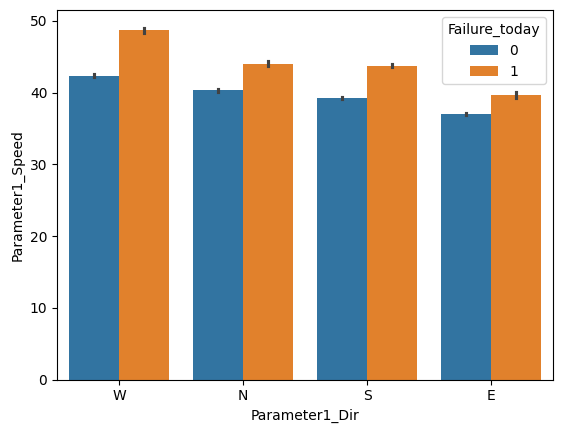

In [80]:
sns.barplot(x="Parameter1_Dir", y="Parameter1_Speed", data=df_nan,hue="Failure_today")
plt.show()

In [81]:
#####################################################################################
####################################################################################
###################################################################################
##################################################################################

# Crear un diccionario para almacenar los outliers
outliers_dict = {}

#buscamos los limites para cada columna y vamos comparando
for col in df_nan.select_dtypes(include='number').columns:
    Q1 = df_nan[col].quantile(0.25)
    Q3 = df_nan[col].quantile(0.75)
    IQR = Q3 - Q1

    # Límites para outliers
    limite_inf= Q1 - 1.5 * IQR
    limite_sup= Q3 + 1.5 * IQR

    # Filas que son outliers en esta columna
    outliers = df_nan[(df_nan[col] < limite_inf) | (df_nan[col] > limite_sup)]

    # Guardar índices de outliers
    outliers_dict[col] = outliers.index.tolist()

for col, idx in outliers_dict.items():
    print(f"Columna: {col} → {len(idx)} outliers")

#ignorar para failure



Columna: Location → 0 outliers
Columna: Min_Temp → 26 outliers
Columna: Max_Temp → 76 outliers
Columna: Leakage → 20331 outliers
Columna: Parameter1_Speed → 2630 outliers
Columna: Parameter3_9am → 1989 outliers
Columna: Parameter3_3pm → 2192 outliers
Columna: Parameter4_9am → 1493 outliers
Columna: Parameter4_3pm → 0 outliers
Columna: Parameter5_9am → 1210 outliers
Columna: Parameter5_3pm → 917 outliers
Columna: Parameter7_9am → 57 outliers
Columna: Parameter7_3pm → 167 outliers
Columna: Failure_today → 25369 outliers


## Pregunta 4 Modelo logit

In [82]:
logit_model = smf.logit("Failure_today ~ Parameter1_Speed + Parameter4_9am + Min_Temp + Parameter7_3pm ", data=df_nan).fit()
print(logit_model.summary())

mfx = logit_model.get_margeff()
print(mfx.summary())

Optimization terminated successfully.
         Current function value: 0.384726
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:          Failure_today   No. Observations:               112925
Model:                          Logit   Df Residuals:                   112920
Method:                           MLE   Df Model:                            4
Date:                Fri, 25 Apr 2025   Pseudo R-squ.:                  0.2778
Time:                        00:06:09   Log-Likelihood:                -43445.
converged:                       True   LL-Null:                       -60159.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -5.9588      0.081    -73.517      0.000      -6.118      -5.800
Parameter1_

## Respuesta pregunta 4

R2 y significancia, sin cambios mayores. Este caso notemos que los cambios por unidad fluctuada de las variables en cuestion han aumentado otra vez, y se repite el patron en el cual la temperatura minima y el parametro 7 afectan mucho mas a la probabilidad de que falle la maquina, es decir, la probabilidad de que falle la maquina es mucho mas sensible a estas variables. los cambios esta vez fueron: 
 - >(probit a logit)
 - parametro velocidad:0,42% -> 0,41% (bajó)
 - parametro 4 9am: 0,77% -> 0,79% (subio)
 - temperatura minima: 2,28% -> 2,31%% (subio)
 - parametro 7 3pm: -2,21%-> -2,24% (subio)

donde en esta ocasion un cambio en una unidad de temperaura minima de la maquina, puede afectar en un 2,31% la probabilidad que falle la maquina, y por otro lado, un cambio de una unidad en el parametro 7 disminuye un 2,24% la probabilidad que ocurra una falla. ademas los cambios fueron bastantes bajos, mas es interesante como el efecto, si bien minimo, de la velocidad del viento, se ve reducido en esta ocasion.

## pregunta 5

Respuesta pregunta 5:
el modelo ols es el peor, pues su estructura no interpreta bien variables que no sean continuas como es el caso de que falle o no la maquina(que es binario), por otro lado los modelos logit y probit estas mas adecuados a esta situación.

Tenemos que los aumentaron, una cierta cantidad, excepto en el parametro1_ la velocidad del viento. Luego, es mas conveniente usar un modelo logit a uno probit, dado que en este caso los datos tienen un rango de valores amplio y en algunos casos asimetricos, por lo que el probit se ajustará un poco peor que el logit, dado que usa la normal para calcular los coeficientes, distriucion que no es asimetrica ni trata de dispersar datos, al contario, de juntarlos en la llamada "campana", mas el modelo logit tiene la caracteristica de ajustarse mejor a los datos mas dispersos dada su naturaleza


<Axes: xlabel='Min_Temp'>

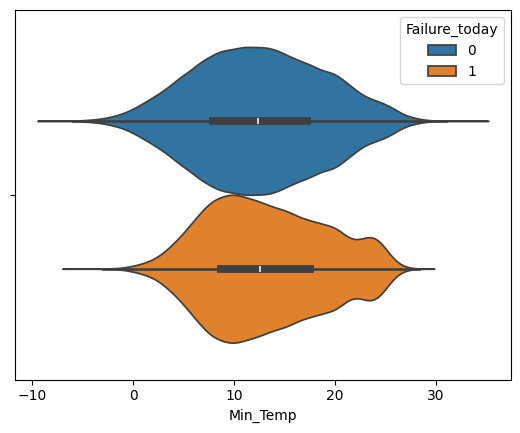

In [83]:
sns.violinplot( x=df_nan["Min_Temp"], hue=df_nan["Failure_today"])

## pregunta 6

In [84]:
# debemos agrupar la data por mes y por fecha
df_nan["Date"].info()

df_fecha=df_nan.copy()

df_nan["Date"].head(10)


<class 'pandas.core.series.Series'>
RangeIndex: 112925 entries, 0 to 112924
Series name: Date
Non-Null Count   Dtype 
--------------   ----- 
112925 non-null  object
dtypes: object(1)
memory usage: 882.4+ KB


0     12/1/2008
1     12/2/2008
2     12/3/2008
3     12/4/2008
4     12/5/2008
5     12/6/2008
6     12/7/2008
7     12/8/2008
8     12/9/2008
9    12/10/2008
Name: Date, dtype: object

In [85]:
# 1. Convertir la fecha correctamente
df_fecha["Date"] = pd.to_datetime(df_fecha["Date"], format="%m/%d/%Y", errors="coerce")

# 2. Filtrar por año (por ejemplo, > 2008)
df_fecha = df_fecha[df_fecha["Date"].dt.year > 2008]

# 3. Crear columna año-mes para agrupar
df_fecha["Mes_Año"] = df_fecha["Date"].dt.to_period("M").astype(str)



In [86]:
# pasamos a location a categorico
df_fecha["Location"] = df_fecha["Location"].astype("category")
df_fecha["Location"] 
# ya tenemos listo location y fechas, procedemos a agrupar y calcular las agregaciones


28         3
29         3
30         3
31         3
32         3
          ..
112920    42
112921    42
112922    42
112923    42
112924    42
Name: Location, Length: 111179, dtype: category
Categories (44, int64): [1, 3, 4, 5, ..., 46, 47, 48, 49]

In [87]:
resumen_nan(df_fecha)



,NaN_count,Total,NaN_percent
Date,0,111179,0.0
Location,0,111179,0.0
Min_Temp,0,111179,0.0
Max_Temp,0,111179,0.0
Leakage,0,111179,0.0
Parameter1_Dir,0,111179,0.0
Parameter1_Speed,0,111179,0.0
Parameter2_9am,0,111179,0.0
Parameter2_3pm,0,111179,0.0
Parameter3_9am,0,111179,0.0


In [88]:
df_grouped = df_fecha.groupby(["Location", "Mes_Año"]).agg({
    "Min_Temp": "mean",
    "Max_Temp": "mean",
    "Leakage": "mean",
    "Parameter1_Speed": "mean",
    "Parameter3_9am": "mean",
    "Parameter3_3pm": "mean",
    "Parameter4_9am": "mean",
    "Parameter4_3pm": "mean",
    "Parameter5_9am": "mean",
    "Parameter5_3pm": "mean",
    "Parameter7_9am": "mean",
    "Parameter7_3pm": "mean",
    "Failure_today": "sum",  # <- suma
}).reset_index()


In [89]:
df_grouped

,Location,Mes_Año,Min_Temp,Max_Temp,Leakage,Parameter1_Speed,Parameter3_9am,Parameter3_3pm,Parameter4_9am,Parameter4_3pm,Parameter5_9am,Parameter5_3pm,Parameter7_9am,Parameter7_3pm,Failure_today
0,1,2009-01,17.975862,31.868966,0.041379,39.965517,10.448276,17.931034,38.689655,23.827586,1014.327586,1012.324138,23.510345,30.579310,0
1,1,2009-02,18.855556,31.485185,0.029630,40.481481,8.481481,18.185185,42.370370,29.407407,1014.540741,1012.822222,23.292593,29.266667,0
2,1,2009-03,15.220833,25.370833,0.891667,37.750000,8.583333,16.750000,59.166667,43.458333,1017.641667,1016.483333,18.716667,23.825000,4
3,1,2009-04,13.207143,22.792857,2.628571,35.857143,10.035714,16.500000,57.821429,45.857143,1019.621429,1017.425000,17.610714,21.360714,6
4,1,2009-05,10.966667,18.170833,1.966667,30.291667,8.458333,11.750000,73.916667,60.833333,1024.575000,1022.308333,14.304167,17.200000,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4351,49,2017-02,19.546429,34.232143,0.000000,46.464286,23.178571,20.928571,49.964286,24.285714,1013.971429,1011.989286,23.560714,32.203571,0
4352,49,2017-03,18.745161,33.732258,0.000000,43.612903,20.387097,18.419355,49.387097,21.806452,1014.780645,1012.367742,22.170968,32.074194,0
4353,49,2017-04,13.572414,24.796552,1.403448,35.758621,18.586207,17.172414,56.034483,38.379310,1022.668966,1019.606897,18.596552,23.644828,4
4354,49,2017-05,9.277419,20.938710,0.341935,33.580645,14.741935,17.290323,65.258065,37.677419,1022.958065,1020.187097,13.806452,20.267742,1


## se obtiene el df_grouped, con la media de las variables, agrupadas por location y periodo mensual

<Axes: xlabel='Failure_today', ylabel='Parameter1_Speed'>

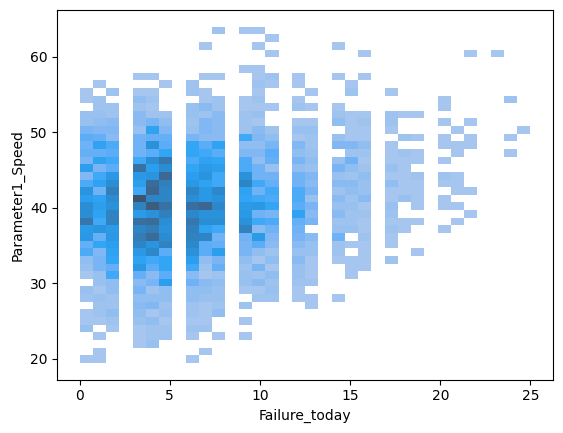

In [90]:
#graficos df_grouped

sns.histplot(y=df_grouped["Parameter1_Speed"], x=df_grouped["Failure_today"])

In [91]:
# Ajustar modelo Poisson
poisson_model = smf.glm(
    formula="Failure_today ~ Parameter1_Speed + Parameter4_9am + Min_Temp + Parameter7_3pm ",
    data=df_grouped,
    family=sm.families.Poisson()
).fit()

# resumen
print(poisson_model.summary())

# ver efectos marginales 
mfx = poisson_model.get_margeff()
print(mfx.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:          Failure_today   No. Observations:                 4076
Model:                            GLM   Df Residuals:                     4071
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9799.2
Date:                Fri, 25 Apr 2025   Deviance:                       6073.3
Time:                        00:06:13   Pearson chi2:                 5.53e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.7980
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0678      0.112  

- __RESPUESTA 6:__ En este caso el modelo poisson, entrega los efectos respecto no a un aumento de la probabilidad que suceda o no, sino a la cantidad de veces que sucede(cantidad de fallos), por ende podemos ver que en este caso los efectos marginales de las variables son: 

- Parameter1_Speed     0.1141
- Parameter4_9am       0.1555
- Min_Temp             0.6432      
- Parameter7_3pm      -0.6112
 y estos indican, por ejemplo para el caso de MIn_temp, el aumento en una unidad tiene un efecto, en promedio, en aumentar la cantidad de fallas en el periodo mensual en 0,65 veces. por otro lado el aumento del parametro7_3pm implica una disminucion en promedio de 0,6 veces en el numero de fallas mensuales.
 
notemos que el efecto mas grande es otra vez con los parametros de min_temp y parametro 7, patron que se viene repitiendo de manera similar

## Pregunta 7 SOBREDISPERSION

In [ ]:
###########################################################
################## SECCION CORREGIDA ######################
###########################################################


poisson_model = smf.glm("Failure_today ~ Parameter1_Speed + Parameter4_9am + Min_Temp + Parameter7_3pm", 
                        data=df_grouped, family=sm.families.Poisson()).fit()

# Guardar el dataframe limpio
df_dispersion = poisson_model.model.data.frame

# Obtener los valores ajustados (fitted values)
mu = poisson_model.fittedvalues

# Nos aseguramos de que los índices sean los mismos
df_dispersion = df_dispersion.loc[mu.index]

# funcion de sobredispersión
aux = ((df_dispersion["Failure_today"] - mu) ** 2 - mu) / mu

# Ajustar un modelo OLS a los residuos
auxr = sm.OLS(aux, mu).fit()

# Imprimir el resumen del modelo OLS
print(auxr.summary())


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.034
Model:                            OLS   Adj. R-squared (uncentered):              0.033
Method:                 Least Squares   F-statistic:                              141.3
Date:                Fri, 25 Apr 2025   Prob (F-statistic):                    4.75e-32
Time:                        09:42:58   Log-Likelihood:                         -8419.6
No. Observations:                4076   AIC:                                  1.684e+04
Df Residuals:                    4075   BIC:                                  1.685e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
####################################
######### SECCION COMENTADA ########

####################################

# Calcular residuos del modelo Poisson
#aux = ((df_grouped["Failure_today"] - poisson_model.mu) ** 2 - poisson_model.mu) / poisson_model.mu

# Ajustar un modelo OLS a estos residuos
#auxr = sm.OLS(aux, poisson_model.mu).fit()

# Imprimir el resumen del modelo OLS para ver los resultados
#print(auxr.summary())


ValueError: operands could not be broadcast together with shapes (4356,) (4076,) 

In [93]:
#aux=((df_grouped["Failure_today"]-poisson_model.mu)**2-poisson_model.mu)/poisson_model.mu
#auxr=sm.OLS(aux,poisson_model.mu).fit()
#print(auxr.summary())

In [104]:
#alpha de poisson
alpha_poisson= np.exp(0.0516)
alpha_poisson

np.float64(1.052954476475184)

__RESPUESTA PREGUNTA 7:__ EL ALPHA PARA LA POISSON NOS DA UN VALOR DE 1.05(significativo) APROXIMADAMENTE.
- Luego, esto indica que hay una sobredispersion considerable, lo que indica que el modelo poisson podria no ser del todo adecuado, ya que este propone que la media sea igual a la varianza, mas este valor de alfa nos indica que la varianza suele aumentar en una magnitud mayor a la media, por lo que no armoniza con lo que propone el modelo de poisson, es decir, en realidad los datos estan mas dispersos de lo que "cree poisson"(sobredispersion).

## Pregunta 8 Binomial negativa


In [109]:
#resultado modelo binomial negativa

nbin = smf.negativebinomial("Failure_today ~ Parameter1_Speed + Parameter4_9am + Min_Temp + Parameter7_3pm", data=df_grouped).fit()
print(nbin.summary())

Optimization terminated successfully.
         Current function value: 2.377483
         Iterations: 26
         Function evaluations: 37
         Gradient evaluations: 37
                     NegativeBinomial Regression Results                      
Dep. Variable:          Failure_today   No. Observations:                 4076
Model:               NegativeBinomial   Df Residuals:                     4071
Method:                           MLE   Df Model:                            4
Date:                Fri, 25 Apr 2025   Pseudo R-squ.:                  0.1414
Time:                        09:51:56   Log-Likelihood:                -9690.6
converged:                       True   LL-Null:                       -11287.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.074

In [106]:
#el valor de la binomial negativa es exp(valor alpha)

alpha_bn= np.exp(0.0580)

#comparamos valores de alpha, el estimado por la regresion auxiliar y el de la binomial
print("alpha poisson: ", alpha_poisson, "alpha BN: ", alpha_bn)

print("diferencia: ", (alpha_bn-alpha_poisson)*100, ", diferencia de menos del 1%")

alpha poisson:  1.052954476475184 alpha BN:  1.0597149957102876
diferencia:  0.6760519235103679 , diferencia de menos del 1%


__Respuesta pregunta 8:__ el valor de alfa estimado por la regresion auxiliar es muy cercano a el real que nos indica la binomial negativa, esto indica que el modelo BN es mas adecuado que el poisson para modelar los datos, puesto que este capta de mejor manera la varianza de ellos.En particular siendo algo mas preciso en numeros de fallas altos, lo que poisson no hace del todo bien, dado que los valores de concentran mas en cantidades de fallas bajas y al no tratar bien la dispersion de los datos, provoca imprecisiones por parte de poisson.

Luego los coeficientes de las variables en cuestion: 
- Parameter1_Speed => exp(0.0187) = 1.018
- Parameter4_9am => exp(0.0255) = 1.025
- Min_Temp => exp(0.1067)  = 1.112
- Parameter7_3pm => exp(-0.1017) = 0.903

luego se tiene que un aumento de una unidad en los parametros, afecta(en su respectivo valor "x" de cada variable) en x veces a la variable failure_today, es decir, para la velocidad del viento por ejemplo, por cada unidad que aumente este, la cantidad de fallos mensuales, en promedio, subira 1.018 veces.

In [107]:
print("Parameter1_Speed =>", np.exp(0.0187),"\n"
      "Parameter4_9am =>", np.exp(0.0255), "\n"
      "Min_Temp =>", np.exp(0.1067),"\n"
      "Parameter7_3pm => ", np.exp(-0.1017))

Parameter1_Speed => 1.018875939981411 
Parameter4_9am => 1.0258279062704445 
Min_Temp => 1.1126004242800154 
Parameter7_3pm =>  0.9033005011747712


## Pregunta 9

__respuesta 9: Existen diferencias en los resultados porque se hacen supuestos en los modelos que en realidad no son del todo asi, como el que realiza poisson con la varianza igual a la media, donde esto en realidad (como podemos ver en la regresion auxiliar) no es asi, sino que en realidad la varianza es mayor, por lo que el modelo poisson no termina de capturar bien toda la informacion, en particular la que esta mas dispersa, tales como un numero de fallas alto por ejemplo. Por lo que, el modelo de la binomial negativa si captura esta dispersion de los datos y ajusta mejor los coeficientes, siendo estos mas representativos.__

 __Por otro lado podemos señalar cierta robustes en los coeficientes, sobre todo en min_temp y parametro 7, ya que estos a pesar del cambio de modelos y metricas calculadas siguen teniendo una participacion no muy variada, por lo que su contribucion es de tal manera que no se ve afectada en gran medida por estos factores(aunque su magnitud si, pero no la forma)(poseen cierta robustez). Luego, por lo dicho anteriormente, se concluye que el modelo mas adecuado en este caso seria el de la binomial negativa.__

In [108]:
df_grouped.shape

(4356, 15)